# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


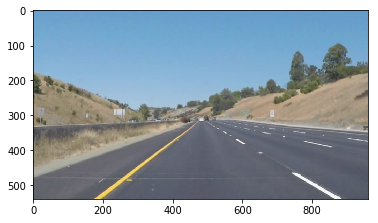

In [2]:
#reading in an image
image_name = "whiteCarLaneSwitch.jpg"
image = mpimg.imread('test_images/' + str(image_name))

#solidWhiteCurve.jpg
#solidWhiteRight.jpg
#solidYellowCurve.jpg
#solidYellowCurve2.jpg
#solidYellowLeft.jpg
#whiteCarLaneSwitch.jpg

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #define parameters for this function
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    global right_line_x_old
    global right_line_y_old
    global left_line_x_old
    global left_line_y_old
    
    #Input from hough-ransformation will be separated into left lines and right lines.
    #Separaration is done by rating the slope (bigger than 0.3 or less than -0.3).
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0.3:
                right_line_x = right_line_x + [x1, x2]
                right_line_y = right_line_y + [y1, y2]
            elif slope < -0.3:
                left_line_x = left_line_x + [x1, x2]
                left_line_y = left_line_y + [y1, y2]
    
    #If there are no valid points out of the houghtransformation for the right line, 
    # I will take the points from the last iteration.
    
    if right_line_x==[]:
        right_line_x = right_line_x_old
        right_line_y = right_line_y_old

    elif right_line_x!=[]:
        right_line_x_old = right_line_x
        right_line_y_old = right_line_y
    
    #With the function polyfit and poly1d I get the f(x)=m*x+n for the right line.
    z_right = np.polyfit(right_line_x, right_line_y, 1)
    f_right = np.poly1d(z_right)
    
    #If there are no valid points out of the houghtransformation for the left line, 
    # I will take the points from the last iteration.
    
    if left_line_x==[]:
        left_line_x = left_line_x_old
        left_line_y = left_line_y_old
        
    elif left_line_x!=[]:
        left_line_x_old = left_line_x
        left_line_y_old = left_line_y

    #With the function polyfit and poly1d I get the f(x)=m*x+n for the left line.
    z_left = np.polyfit(left_line_x, left_line_y, 1)
    f_left = np.poly1d(z_left)
    
    #Define parameters for this function
    i = []
    j = []
    count_i = 0
    count_j = 0
    x1_old_i = 0
    y1_old_i = 0
    x1_old_j = 0
    y1_old_j = 0
    max_x = img.shape[1]
    Divider = 20 # Divider for 5 % Steps
    area_right_x1 = max_x //2 + max_x // Divider * 1 # define the area from x1 to x2 for the right line depending on the image size
    area_right_x2 = max_x - max_x // Divider * 1 # define the area from x1 to x2 for the right line depending on the image size
    area_left_x2 = max_x //2 - max_x // Divider * 1 # define the area from x1 to x2 for the left line depending on the image size
    area_left_x1 = max_x // Divider * 1 # define the area from x1 to x2 for the left line depending on the image size
    
    #The first step is to calculate 300 Points between the area x1 to x2 for the calculatet function f(x).
    #The second step is to draw the lines from point to point over all 300 Points.
    for x1 in np.linspace(area_right_x1, area_right_x2, 300):
        if count_i == 0:
            x1_old_i = x1.astype(int) 
            y1_old_i = f_right(x1).astype(int)
            count_i += 1
        elif count_i > 0:
            cv2.line(img, (x1_old_i, y1_old_i), (x1.astype(int), f_right(x1).astype(int)), color, thickness)
            x1_old_i = x1.astype(int) 
            y1_old_i = f_right(x1).astype(int)
            count_i += 1
    
    #The first step is to calculate 300 Points between the area x1 to x2 for the calculatet function f(x).
    #The second step is to draw the lines from point to point over all 300 Points.
    for x1 in np.linspace(area_left_x1, area_left_x2, 300):
        if count_j == 0:
            x1_old_j = x1.astype(int) 
            y1_old_j = f_left(x1).astype(int)
            count_j += 1
        elif count_j > 0:
            cv2.line(img, (x1_old_j, y1_old_j), (x1.astype(int), f_left(x1).astype(int)), color, thickness)
            x1_old_j = x1.astype(int) 
            y1_old_j = f_left(x1).astype(int)
            count_j += 1


    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #If the output of the houghtransformation will generate a 'None' value, the draw_line function has to be cancelled
    # (Challenge Video, because of the gap on the asphalt street)
    if lines is None:
        return line_img
    
    draw_lines(line_img, lines)
    return line_img



def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Grayscale Transformation

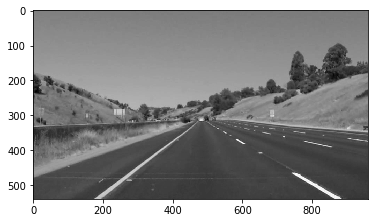

In [5]:
#Call grayscale transform: This will return an image with only one color channel
gray = grayscale(image)
plt.imshow(gray, cmap='gray')



## Apply Gaussian Smoothing

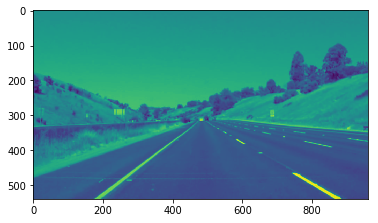

In [6]:
#Parameterize and call the gaussian noise kernel
kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)

plt.imshow(blur_gray)

## Parameter + Canny

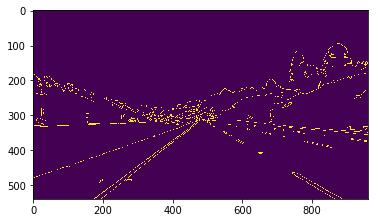

In [7]:
#Parameterize and call the canny transformation
low_threshold = 50
high_threshold = 150

edges = canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges)

## Parameter + Region of Interests

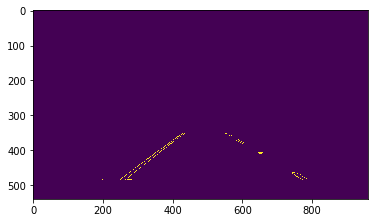

In [8]:
#Parameterize and calculate the Region of Interest depending on the image size

#Image dimension
max_y = image.shape[0]
max_x = image.shape[1]
Divider = 20 # Divider for 5 % Steps
#define a Polygon of 4 Points with x and y coordinates
Point1_x = 0 + max_x // Divider * 3 # 3% from max Image as Integer
Point1_y = max_y // Divider * 18 # 18% from max Image [fading out the hood]
Point2_x = max_x //2 - max_x // Divider * 2 # 2% from the middle of the image to the left side as Integer
Point2_y = max_y // Divider * 13 # 13% from max Image [Horizont]
Point3_x = max_x //2 + max_x // Divider * 2 # 2% from the middle of the image to the right side as Integer
Point3_y = max_y // Divider * 13 # 13% from max Image [Horizont]
Point4_x = max_x - max_x // Divider * 3 # 97% von max Image als Integer
Point4_y = max_y // Divider * 18 # 18% from max Image [fading out the hood]

vertices = np.array([[(Point1_x, Point1_y), 
                  (Point2_x, Point2_y), 
                  (Point3_x, Point3_y), 
                  (Point4_x, Point4_y)]], 
                  dtype=np.int32)

#Call the region of interest
masked_edges = region_of_interest(edges, vertices)

plt.imshow(masked_edges)

## Parameter + Houghtransformation + Draw Lines

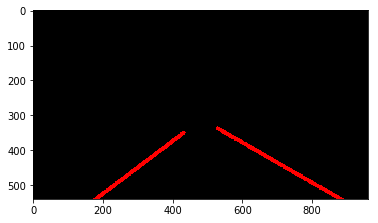

In [9]:
# Parameterize the Hough transformation
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

# Make a blank the same size as the original image to draw on
line_image = np.copy(masked_edges)*0 

#Call the hough transformation
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

plt.imshow(line_image)

## Weighted Image

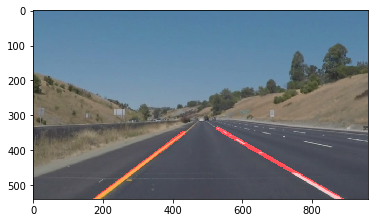

In [10]:
#Call the weighted image with 100% transparency from original image and 80% from the 
# line_image.
sum_image = weighted_img(line_image, image, α=0.8, β=1.0, λ=0.0)
plt.imshow(sum_image)

#Saving the sum-image to "test_images_output"
#mpimg.imsave(os.path.join("test_images_output/","final_" + str(image_name)), sum_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    #Step1.0: Function call "grayscale"
    gray = grayscale(image) 
    
    #Step2.0: Parametrization
    kernel_size = 7
    #Step2.1: Function call "gaussian_blur"
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #Step3.0: Parametrization
    low_threshold = 50
    high_threshold = 150

    #Step3.1: Function call "canny"
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    #Step4.0: Parametrization
    max_y = image.shape[0]
    max_x = image.shape[1]
    Divider = 20 # Divider for 5 % Steps
    Point1_x = 0 + max_x // Divider * 3 # 3% from max Image as Integer
    Point1_y = max_y // Divider * 18 # 18% from max Image [fading out the hood]
    Point2_x = max_x //2 - max_x // Divider * 2 # 2% from the middle of the image to the left side as Integer
    Point2_y = max_y // Divider * 13 # 13% from max Image [Horizont]
    Point3_x = max_x //2 + max_x // Divider * 2 # 2% from the middle of the image to the right side as Integer
    Point3_y = max_y // Divider * 13 # 13% from max Image [Horizont]
    Point4_x = max_x - max_x // Divider * 3 # 97% von max Image als Integer
    Point4_y = max_y // Divider * 18 # 18% from max Image [fading out the hood]
    #Step4.1: Define vertices
    vertices = np.array([[(Point1_x, Point1_y), 
                      (Point2_x, Point2_y), 
                      (Point3_x, Point3_y), 
                      (Point4_x, Point4_y)]], 
                      dtype=np.int32)

    #Step4.2: Function call "region_of_interest"
    masked_edges = region_of_interest(edges, vertices)
    
    #Step5.0: Parametrization
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    #Step5.1: Make a blank the same size as our image to draw on
    line_image = np.copy(masked_edges)*0 # creating a blank to draw lines on

    #step5.2: Function call "hough_lines"
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    #Step6.0: Function call "weighted_img"
    sum_image = weighted_img(line_image, image, α=0.8, β=1.0, λ=0.0)
    
    result = np.copy(sum_image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

#Parametrization
global right_line_x_old
global right_line_y_old
global left_line_x_old
global left_line_y_old
right_line_x_old = []
right_line_y_old = []
left_line_x_old = []
left_line_y_old = []


clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:11<00:00, 17.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 16.6 s, sys: 360 ms, total: 16.9 s
Wall time: 11.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)

#Parametrization
global right_line_x_old
global right_line_y_old
global left_line_x_old
global left_line_y_old
right_line_x_old = []
right_line_y_old = []
left_line_x_old = []
left_line_y_old = []

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:36<00:00, 17.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 52.9 s, sys: 1.05 s, total: 53.9 s
Wall time: 37.1 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

#Parametrization
global right_line_x_old
global right_line_y_old
global left_line_x_old
global left_line_y_old
right_line_x_old = []
right_line_y_old = []
left_line_x_old = []
left_line_y_old = []

clip3 = VideoFileClip('test_videos/challenge.mp4') #.subclip(0,4)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:16<00:00, 15.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 22.1 s, sys: 592 ms, total: 22.7 s
Wall time: 17.2 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

My pipeline consisted of 6 steps (they are shown and commented in the function process_image). 

First, I converted the images to grayscale, then I run the gaussian blur to smooth the gray images. Afterwards the  Canny function will detect a strong gradient of pixels. Accept those which are above the high_threshold (150) and reject pixels which are below the low_threshold (50). The output is a binary image with white pixels (the detected edges) and black pixels everywhere else.

At step 4 I defined the region of interest, by calculating a four sided polygon. The coordinates depends on the image size in pixels and are defined like this:
    Point1_x = 3% from max Image as Integer
    Point1_y = 18% from max Image [fading out the hood]
    Point2_x = 2% from the middle of the image to the left side as Integer
    Point2_y = 13% from max Image [Horizont]
    Point3_x = 2% from the middle of the image to the right side as Integer
    Point3_y = 13% from max Image [Horizont]
    Point4_x = 97% von max Image als Integer
    Point4_y = 18% from max Image [fading out the hood]
Afterwards I filled in the pixels inside the polygon into an empty (black) image to get only the possible lane lines in the region of interest.

At the next step number 5 I called the function hough_lines to calculate various arrayas of lines, which lay on the detected lanes. In my subfunction draw_lines I enlarged the main function of drawing lines. The detailed steps are explained in the next sections.
In order to draw a single line on the left and right lanes, I modified the draw_lines() function by separating the  output from hough-ransformation into left lines and right lines. The separaration is done by rating the slope (bigger than 0.3 or less than -0.3).
If there are no valid points out of the houghtransformation for the left or right line, I will take the points from the last iteration (this is a workaround, because the houghtransformation can't find valid functions with the named static parameters, to work with all images and videos).
With the function polyfit and poly1d I get the f(x)=m*x+n for the left and right line.
Afterwards I calculated 300 Points between the area x1 to x2 for the calculatet function f(x). So I get the coordinates/points to draw the line, extraplated from the bottom to the horizont, for the left and the right lane.

The last step number 6 ist to overlay the original image with the lane image (output of the draw_line function) to show the detected lane lines in front of the car. See also the Chapter Results for a collection of all processed test images.


### 2. Identify potential shortcomings with your current pipeline

One potential shortcoming would be what would happen when a gap on the aspahlt street is identified as a lane line (e.g. Video from "challenge").


### 3. Suggest possible improvements to your pipeline

A possible improvement would be to form a curve by defining the region of interest, as well as the calculated function from polyfit. Because now the region of interest ist straight and the polyfit is a linear function.



## Results 

The Results from all pictures at "test_images" are saved in the folder  "test_images_output". The output of code below shows all images which are separatly generated with the code above.

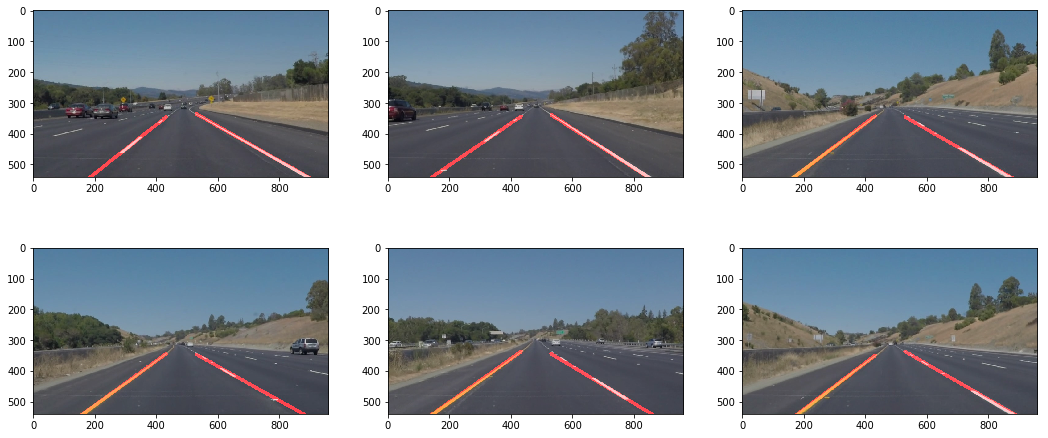

In [19]:
import os
from skimage.io import imread_collection, imshow_collection

#Parametrization
i=1
col_dir = 'test_images_output/*.jpg'

#creating a collection with the available images
col = imread_collection(col_dir)

#Plot all images into a collection
plt.figure(figsize=(18,8))
for final_img in col:
    plt.subplot(2,3,i).imshow(final_img)
    i += 1
